# Data Collection And Preprocessing

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers

from sklearn.model_selection import train_test_split

## Load The dataset

In [2]:
Image_directory = "PotatoData"
Image_size = 256
Batch_size = 32
Channels = 3
Epochs = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=Image_directory,
    shuffle= True,
    image_size=(Image_size, Image_size),
    batch_size=Batch_size
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 2 1 0 1 2 1 1 0 0 0 1 1 1 0 1 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0]


## Visualization

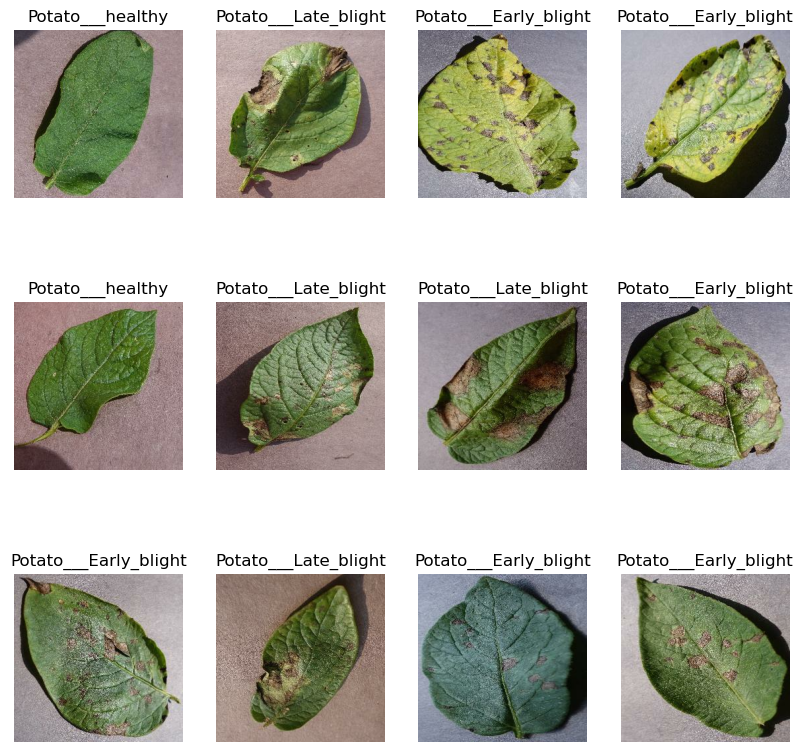

In [7]:
for image_batch, label_batch in dataset.take(1):
    plt.figure(figsize=(10,10))
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

## Split Train Test

80% ==> Training <br>
20% ==> 10% Validation, 10% Test

In [8]:
len(dataset)

68

In [9]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_dataset = dataset.take(54)
len(train_dataset)

54

In [11]:
test_dataset = dataset.skip(54)
len(test_dataset)

14

In [12]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_dataset = test_dataset.take(6)
len(val_dataset)

6

In [14]:
test_dataset = test_dataset.skip(6)
len(test_dataset)

8

In [15]:
# To take tensorflow dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


## Optimize Tensorflow Pipeline Performance

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Normalization

In [19]:
resize_and_scale = tf.keras.Sequential([
    layers.Resizing(Image_size, Image_size),  # This for when use model for predictions
    layers.Rescaling(1.0/255)
])

## Data Augmentation

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

# Model Building

## Convolution Neural Network Architecture

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

Input_shape = (Batch_size, Image_size, Image_size, Channels)
N_of_classes = 3

model = Sequential()

model.add(resize_and_scale)
model.add(data_augmentation)

model.add(Conv2D(32, (3,3), activation="relu", input_shape=Input_shape))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPool2D((2,2)))

model.add(Flatten())

model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(N_of_classes, activation="softmax"))

model.build(input_shape=Input_shape)

# Early stopping to stop training when the model stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reduce learning rate when the validation loss has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Model checkpoint to save the best model
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)


# Compile
model.compile(optimizer="adam", loss=SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])

C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
# Summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 64)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [23]:
history = model.fit(
    train_ds,
    epochs=Epochs,
    batch_size=Batch_size,
    validation_data=val_ds,
    verbose=1,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 50s 806ms/step - accuracy: 0.4629 - loss: 0.9974 - val_accuracy: 0.5208 - val_loss: 0.7894 - learning_rate: 0.0010
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 689ms/step - accuracy: 0.5955 - loss: 0.8182 - val_accuracy: 0.7708 - val_loss: 0.5182 - learning_rate: 0.0010
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 770ms/step - accuracy: 0.7251 - loss: 0.5879 - val_accuracy: 0.8698 - val_loss: 0.3864 - learning_rate: 0.0010
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 785ms/step - accuracy: 0.8041 - loss: 0.4655 - val_accuracy: 0.8802 - val_loss: 0.3606 - learning_rate: 0.0010
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 768ms/step - accuracy: 0.8454 - loss: 0.3943 - val_accuracy: 0.9062 - val_loss: 0.2601 - learning_rate: 0.0010
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 704ms/step - accuracy: 0.8518 - loss: 0.3660 - val_accuracy: 0.8698 - val_loss: 0.3006 - learning_rate: 0.0010
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 770ms/step - accuracy: 0.9094 - loss: 0.

## Model Evaluation

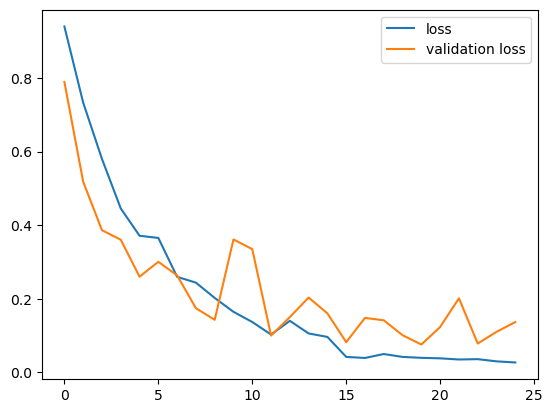

In [24]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.show()

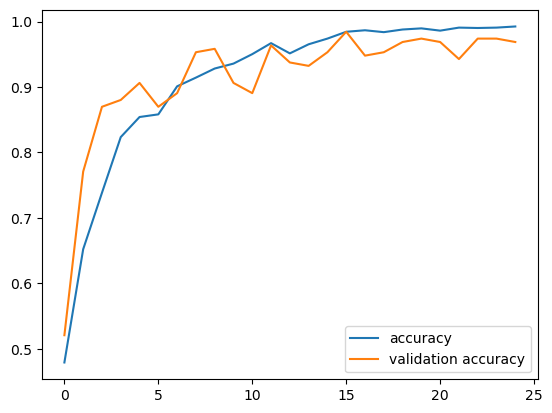

In [25]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="validation accuracy")
plt.legend()
plt.show()

In [26]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.9881 - loss: 0.0354


In [27]:
scores

[0.03871600329875946, 0.98828125]

In [28]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [29]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

## Predictions

In [1]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    plt.axis("off")
    
    print("Actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted label: ", class_names[np.argmax(batch_prediction[0])])

NameError: name 'test_ds' is not defined

In [46]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


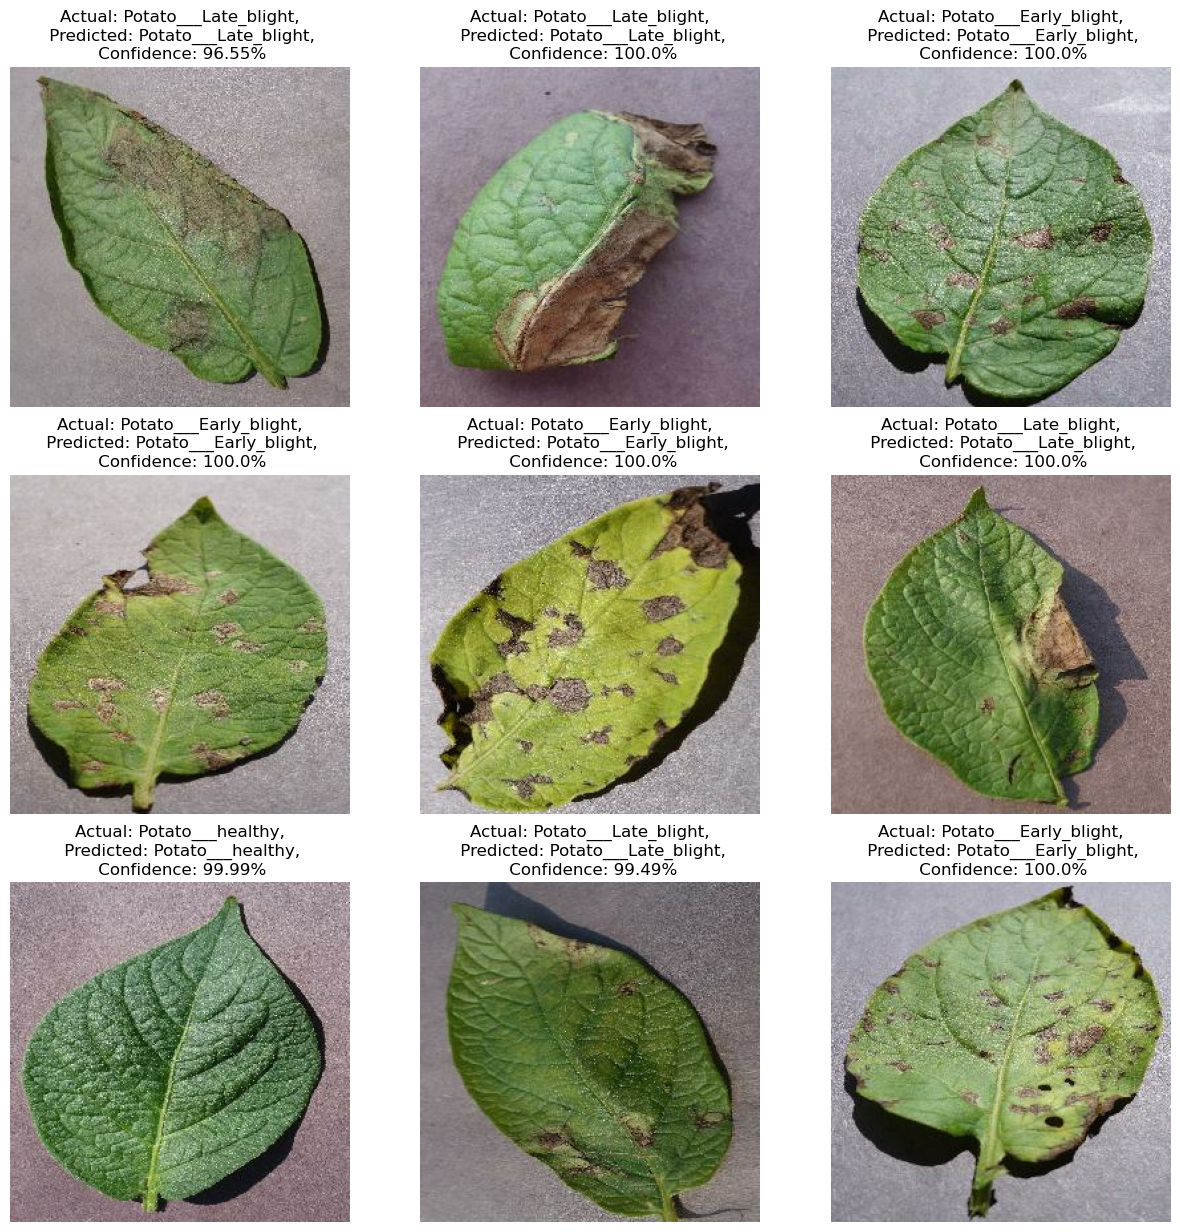

In [51]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%")
        
        plt.axis("off")

## Save The Model

In [49]:
import os

# List all items in the directory and filter out non-numeric filenames
model_versions = [int(i) for i in os.listdir("../models") if i.isdigit()]

# If no numeric filenames are found, start with version 0
if not model_versions:
    model_version = 0
else:
    model_version = max(model_versions) + 1

# Save the model with the new version number
model.save(f"../models/model_{model_version}.keras")

## Prediction Pipeline For Custom Input Data

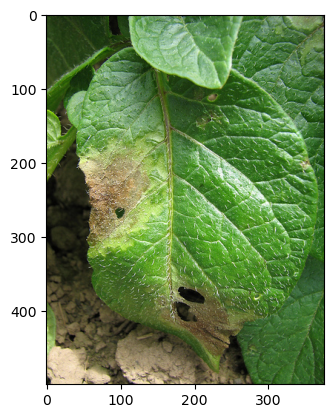

In [228]:
from PIL import Image

img = Image.open("late.JPG")
plt.imshow(img)
plt.show()

In [229]:
img = np.array(img)
img.shape

(500, 375, 3)

In [230]:
img_resized = cv2.resize(img, (Image_size, Image_size))
img_resized.shape

(256, 256, 3)

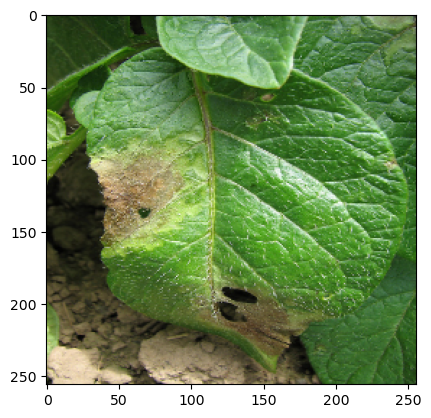

In [231]:
plt.imshow(img_resized)
plt.show()

In [232]:
img_final = img_resized[np.newaxis, ...]
img_final.shape

(1, 256, 256, 3)

In [233]:
predic = model.predict(img_final)
Disease = np.argmax(predic)

print("Prediction: ")
if Disease == 0 :
    print("\tEarly Blight")
elif Disease == 1 :
    print("\tLate Blight")
else:
    print("\tHealthy")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction: 
	Late Blight
